# Sentiment Timeseries

In [2]:
import pandas as pd
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
df = pd.read_csv(pathlib.Path("../data/news_select_companies_with_sent.csv"))
df

,Unnamed: 0,id,ticker,title,category,content,release_date,provider,url,article_id,dic_sentiment,dic_sentiment_dis
0,1305,222820,MSFT,Microsoft exposed 250M customer support records,news,Microsoft MSFT 0 1 discloses a database er...,2020-01-23,Seeking Alpha,https://invst.ly/pli4a,2065317,-0.0258,-1
1,1307,222822,MSFT,Microsoft CEO Fears U S China Mistrust Will H...,news,Bloomberg Sign up here to receive the Dav...,2020-01-21,Bloomberg,https://www.investing.com/news/stock-market-ne...,2063837,0.9620,1
2,3760,225275,MSFT,China Coronavirus Sells Off Asian Markets,opinion,Tuesday January 21 2020Market futures are in...,2020-01-20,Zacks Investment Research,https://www.investing.com/analysis/china-coron...,200500300,0.6584,1
3,3761,225276,MSFT,Tech Daily Facebook Apple Digital Taxes More,opinion,Facebook s NASDAQ FB role in elections and...,2020-01-21,Zacks Investment Research,https://www.investing.com/analysis/tech-daily-...,200500369,0.9970,1
4,3762,225277,MSFT,Chart Of The Day Can IBM s Results Help Avert...,opinion,International Business Machines NYSE IBM is ...,2020-01-21,Pinchas Cohen/Investing.com,https://www.investing.com/analysis/chart-of-th...,200500192,0.0979,1
...,...,...,...,...,...,...,...,...,...,...,...,...
60390,221241,442757,PFE,PSivida Small Cap BioTech Positioned For Long...,opinion,The following small cap company I find very in...,2012-04-18,Scott Matusow,https://www.investing.com/analysis/psivida:-sm...,120599,0.9997,1
60391,221246,442762,PFE,Cheap Is Not Always Good And Stocks As Sweaters,opinion,Cheap Is Not Always GoodThere are many investo...,2011-11-23,Helix Investment Management,https://www.investing.com/analysis/cheap-is-no...,106549,0.9922,1
60392,221247,442763,PFE,PROLOR Biotech A Top Takeover Candidate,opinion,Billionaire Phillip Frost is an esteemed entre...,2011-12-06,Takeover Analyst,https://www.investing.com/analysis/prolor-biot...,107900,0.9941,1
60393,221248,442764,PFE,2 Defensive Dividend Stocks Outperforming The SP,opinion,Looking to play defense in the market As the ...,2011-12-19,Double Dividend Stocks,https://www.investing.com/analysis/2-defensive...,109101,0.9951,1


# Data cleaning

In [4]:
sentiment_df = df[["ticker", "release_date", "dic_sentiment"]]


dates = sentiment_df["release_date"]
sentiment_df.index = pd.DatetimeIndex(dates)
del sentiment_df["release_date"]
sentiment_df.sort_values(by='release_date')


sentiment_df = sentiment_df.pivot_table(index = sentiment_df.index, columns=['ticker'], values='dic_sentiment')

sentiment_df

ticker,AAPL,AMZN,BAC,CVX,HD,JNJ,JPM,KO,LLY,MA,MRK,MSFT,NVDA,PFE,PG,TSLA,UNH,V,WMT,XOM
release_date,,,,,,,,,,,,,,,,,,,,
2008-10-06,NaN,NaN,NaN,-0.9949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-10-07,NaN,NaN,-0.9713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-10-15,NaN,NaN,NaN,NaN,-0.99855,NaN,NaN,NaN,NaN,NaN,NaN,0.03855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-10-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.9717,NaN
2008-10-31,NaN,NaN,0.6914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-09,NaN,NaN,NaN,0.9797,NaN,0.992700,0.860600,NaN,NaN,NaN,NaN,NaN,-0.42150,NaN,NaN,NaN,NaN,NaN,0.3612,NaN
2020-02-10,NaN,NaN,NaN,NaN,NaN,NaN,0.439500,NaN,NaN,0.9851,0.7672,NaN,0.76662,NaN,NaN,NaN,NaN,NaN,NaN,-0.176867
2020-02-11,NaN,NaN,NaN,0.0366,NaN,0.774133,0.219044,NaN,NaN,NaN,NaN,NaN,NaN,0.512767,NaN,NaN,NaN,NaN,NaN,0.996300


# Monthly average and monthly sum

In [5]:
monthly_average_df = sentiment_df.resample("MS").mean()
monthly_average_df = monthly_average_df.fillna(method="ffill")
monthly_average_df

ticker,AAPL,AMZN,BAC,CVX,HD,JNJ,JPM,KO,LLY,MA,MRK,MSFT,NVDA,PFE,PG,TSLA,UNH,V,WMT,XOM
release_date,,,,,,,,,,,,,,,,,,,,
2008-10-01,NaN,NaN,-0.139950,-0.994900,-0.998550,NaN,NaN,NaN,NaN,NaN,NaN,0.038550,NaN,NaN,NaN,NaN,NaN,NaN,-0.971700,NaN
2008-11-01,NaN,NaN,-0.707481,-0.994900,-0.987100,NaN,0.975100,NaN,NaN,NaN,NaN,0.038550,NaN,NaN,NaN,NaN,NaN,NaN,0.322633,NaN
2008-12-01,NaN,NaN,-0.608929,-0.972200,-0.987100,NaN,-0.853800,NaN,NaN,NaN,NaN,0.891350,NaN,0.993300,NaN,NaN,NaN,NaN,0.624900,NaN
2009-01-01,NaN,NaN,-0.375701,-0.972200,0.116200,NaN,-0.853800,NaN,NaN,NaN,NaN,0.949000,NaN,0.993300,NaN,NaN,NaN,NaN,-0.997000,NaN
2009-02-01,NaN,NaN,0.016350,-0.263433,-0.994300,NaN,-0.975800,-0.918600,NaN,NaN,NaN,0.510600,NaN,0.993300,NaN,NaN,NaN,NaN,0.085400,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-01,0.727041,0.516684,0.605170,0.349735,0.981200,0.496181,0.275249,0.640518,0.829562,0.141157,0.907360,0.800642,-0.018280,0.897583,0.926770,0.631839,0.741175,0.818342,0.184125,0.519429
2019-11-01,0.697606,0.551874,0.748092,0.314312,0.801758,0.761719,0.472428,0.904773,0.596906,0.637330,0.958071,0.799192,0.308463,0.604933,0.992589,0.599049,0.828093,0.686867,0.464662,0.666542
2019-12-01,0.809745,0.638340,0.688967,0.745112,0.880300,0.886783,0.474379,0.957873,0.973050,0.758764,0.911601,0.803239,0.642958,0.965800,0.949622,0.601794,0.981800,0.153637,0.484628,0.647223


In [6]:
monthly_sum_df = sentiment_df.resample("MS").sum()
monthly_sum_df

ticker,AAPL,AMZN,BAC,CVX,HD,JNJ,JPM,KO,LLY,MA,MRK,MSFT,NVDA,PFE,PG,TSLA,UNH,V,WMT,XOM
release_date,,,,,,,,,,,,,,,,,,,,
2008-10-01,0.000000,0.000000,-0.279900,-0.994900,-0.998550,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.038550,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.971700,0.000000
2008-11-01,0.000000,0.000000,-5.659850,0.000000,-0.987100,0.000000,0.975100,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.967900,0.000000
2008-12-01,0.000000,0.000000,-7.307150,-1.944400,0.000000,0.000000,-0.853800,0.000000,0.00000,0.000000,0.000000,1.782700,0.000000,0.993300,0.000000,0.000000,0.000000,0.000000,0.624900,0.000000
2009-01-01,0.000000,0.000000,-5.635514,0.000000,0.232400,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2.847000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.997000,0.000000
2009-02-01,0.000000,0.000000,0.245250,-0.790300,-0.994300,0.000000,-0.975800,-0.918600,0.00000,0.000000,0.000000,0.510600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.085400,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-01,20.357161,13.433774,15.129247,2.797883,4.906000,8.435083,7.156480,8.967255,10.78430,2.258517,4.536800,21.617331,-0.201083,5.385500,9.267700,17.059647,5.188225,3.273367,2.209500,12.466299
2019-11-01,18.137767,14.900605,17.954205,2.514500,6.414067,6.093750,10.393415,18.095452,5.37215,6.373300,6.706500,20.778986,2.467700,1.814800,8.933300,13.179071,5.796650,2.060600,7.434600,14.663918
2019-12-01,25.102093,14.681830,15.157265,7.451123,3.521200,5.320700,9.961967,23.946818,7.78440,5.311350,12.762417,21.687465,3.857750,1.931600,8.546600,18.053825,0.981800,0.614550,4.361650,14.238912


<AxesSubplot: xlabel='release_date'>

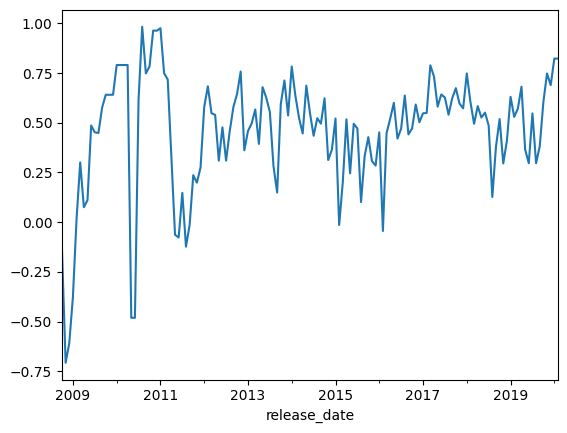

In [7]:
monthly_average_df["BAC"].plot()

In [8]:
def plot_sentiment(df, title):

    # Group the tickers by 5 so the plot doesn't get too crowded
    tickers = []
    five_tickers = []
    for i, ticker in enumerate(df.columns):
        i+=1
        five_tickers.append(ticker)
        if i % 5 == 0:
            tickers.append(five_tickers)
            five_tickers = []


    plt.figure(figsize= (11, 11))
    for i, five_tickers in enumerate(tickers):
        i+=1
        plt.subplot(2, 2, i)

        for ticker in five_tickers:
            df[ticker].plot()
        plt.ylabel("sentiment")
        plt.legend(five_tickers)

    plt.title(title)
    plt.show()

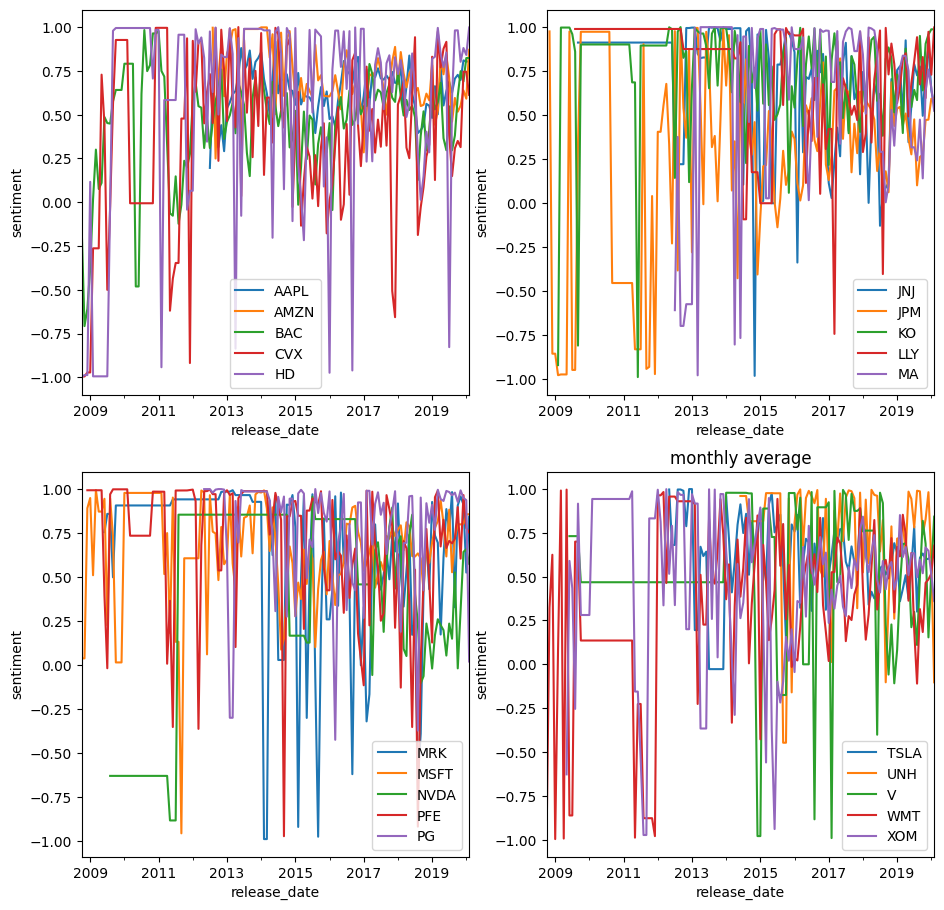

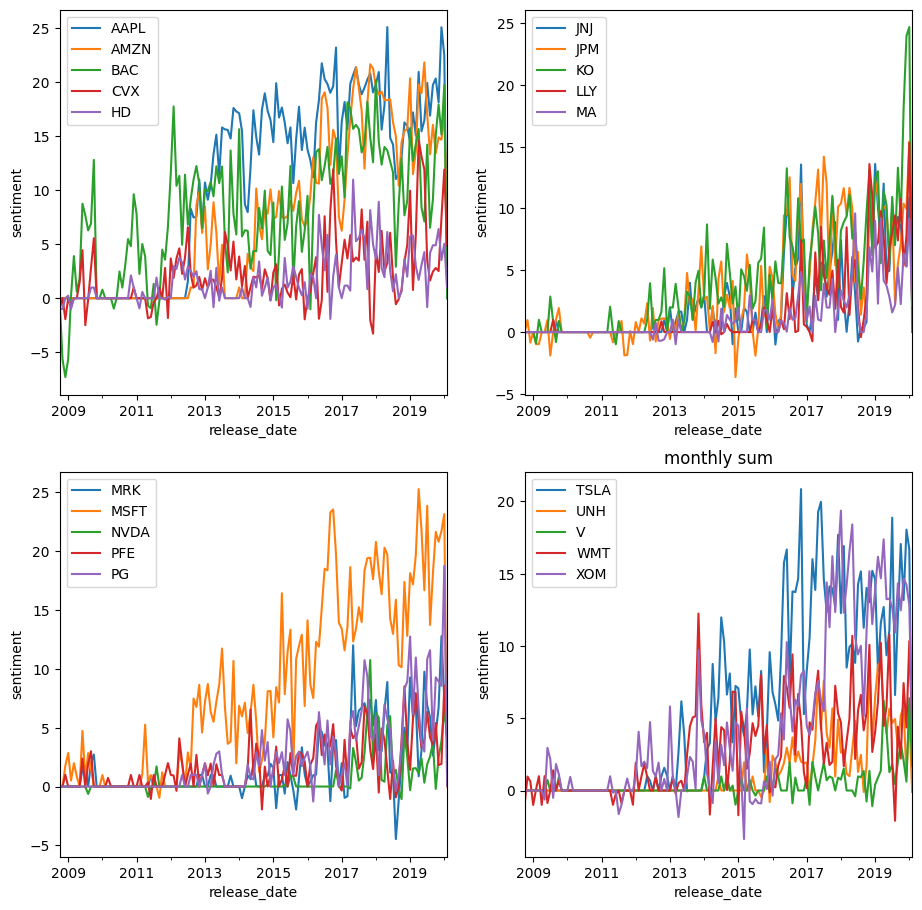

In [9]:
plot_sentiment(monthly_average_df, "monthly average")
plot_sentiment(monthly_sum_df, "monthly sum")

In [10]:
def CMA_monthly(ticker, df, N):
    """
    Take the monthly average of the sentiment values.

    ticker_df: pd.DataFrame with dates (dt.datetime) and sentiments values.

    Returns a list of the new dates where the days are set to 1 and a list
    of the monthly average sentiment values.
    """
    average_sentiments = []
    df = df[df[ticker].notna()]
    first_date = df.index[0]
    current_month = first_date.month
    months = [pd.Timestamp(first_date.year, first_date.month, 1)]
    sentiments = [df[ticker].iloc[0]]
    n_months = 0

    for date, row in df.iterrows():
        sentiments.append(row[ticker])

        if date.month != current_month:
            n_months += 1
            months.append(pd.Timestamp(date.year, date.month, 1))
            average_sentiments.append(np.mean(sentiments))
            current_month = date.month

        if n_months == N:
            sentiments = []
            n_months = 0

    average_sentiments.append(np.mean(sentiments))

    return months, average_sentiments

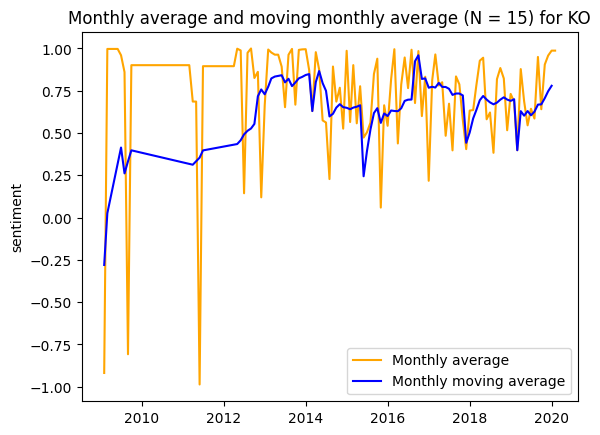

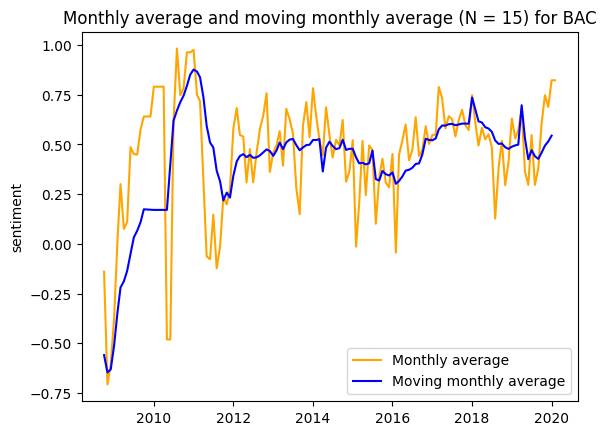

In [11]:
N = 15
months, average_sentiments = CMA_monthly("KO", sentiment_df, N)

plt.plot(monthly_average_df.index, monthly_average_df["KO"], color = "orange", label = "Monthly average")
plt.plot(months, average_sentiments, color = "blue", label = "Monthly moving average")
plt.ylabel("sentiment")
plt.title(f"Monthly average and moving monthly average (N = {N}) for KO")
plt.legend()
plt.show()

months, average_sentiments = CMA_monthly("BAC", sentiment_df, 15)

plt.plot(monthly_average_df.index, monthly_average_df["BAC"], color = "orange", label = "Monthly average")
plt.plot(months, average_sentiments, color = "blue", label = "Moving monthly average")
plt.ylabel("sentiment")
plt.legend()
plt.title(f"Monthly average and moving monthly average (N = {N}) for BAC")
plt.show()

In [12]:
for ticker in monthly_average_df.columns:
    monthly_average_df = monthly_average_df.rename(columns = {f"{ticker}": f"{ticker}_mean"})
    monthly_sum_df = monthly_sum_df.rename(columns = {f"{ticker}": f"{ticker}_sum"})

sentiment_data_df = pd.concat([monthly_average_df, monthly_sum_df], axis =1)
sentiment_data_df

ticker,AAPL_mean,AMZN_mean,BAC_mean,CVX_mean,HD_mean,JNJ_mean,JPM_mean,KO_mean,LLY_mean,MA_mean,...,MRK_sum,MSFT_sum,NVDA_sum,PFE_sum,PG_sum,TSLA_sum,UNH_sum,V_sum,WMT_sum,XOM_sum
release_date,,,,,,,,,,,,,,,,,,,,,
2008-10-01,NaN,NaN,-0.139950,-0.994900,-0.998550,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.038550,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.971700,0.000000
2008-11-01,NaN,NaN,-0.707481,-0.994900,-0.987100,NaN,0.975100,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.967900,0.000000
2008-12-01,NaN,NaN,-0.608929,-0.972200,-0.987100,NaN,-0.853800,NaN,NaN,NaN,...,0.000000,1.782700,0.000000,0.993300,0.000000,0.000000,0.000000,0.000000,0.624900,0.000000
2009-01-01,NaN,NaN,-0.375701,-0.972200,0.116200,NaN,-0.853800,NaN,NaN,NaN,...,0.000000,2.847000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.997000,0.000000
2009-02-01,NaN,NaN,0.016350,-0.263433,-0.994300,NaN,-0.975800,-0.918600,NaN,NaN,...,0.000000,0.510600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.085400,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-01,0.727041,0.516684,0.605170,0.349735,0.981200,0.496181,0.275249,0.640518,0.829562,0.141157,...,4.536800,21.617331,-0.201083,5.385500,9.267700,17.059647,5.188225,3.273367,2.209500,12.466299
2019-11-01,0.697606,0.551874,0.748092,0.314312,0.801758,0.761719,0.472428,0.904773,0.596906,0.637330,...,6.706500,20.778986,2.467700,1.814800,8.933300,13.179071,5.796650,2.060600,7.434600,14.663918
2019-12-01,0.809745,0.638340,0.688967,0.745112,0.880300,0.886783,0.474379,0.957873,0.973050,0.758764,...,12.762417,21.687465,3.857750,1.931600,8.546600,18.053825,0.981800,0.614550,4.361650,14.238912


In [13]:
for ticker in sentiment_df.columns:
    sentiment_data_df[f"{ticker}_run_mean"] = float("nan")
    months, average_sentiments = CMA_monthly(ticker, sentiment_df, 15)
    for month, average_sentiment in zip(months, average_sentiments):
        sentiment_data_df.loc[month, f"{ticker}_run_mean"] = average_sentiment

sentiment_data_df = sentiment_data_df.reindex(sorted(sentiment_data_df.columns), axis=1)
sentiment_data_df = sentiment_data_df.fillna(method="ffill")
sentiment_data_df["BAC_run_mean"]

release_date
2008-10-01   -0.559525
2008-11-01   -0.646554
2008-12-01   -0.632160
2009-01-01   -0.512082
2009-02-01   -0.345228
                ...   
2019-10-01    0.458554
2019-11-01    0.494227
2019-12-01    0.515110
2020-01-01    0.544374
2020-02-01    0.544374
Freq: MS, Name: BAC_run_mean, Length: 137, dtype: float64

In [14]:
sentiment_data_df

ticker,AAPL_mean,AAPL_run_mean,AAPL_sum,AMZN_mean,AMZN_run_mean,AMZN_sum,BAC_mean,BAC_run_mean,BAC_sum,CVX_mean,...,UNH_sum,V_mean,V_run_mean,V_sum,WMT_mean,WMT_run_mean,WMT_sum,XOM_mean,XOM_run_mean,XOM_sum
release_date,,,,,,,,,,,,,,,,,,,,,
2008-10-01,NaN,NaN,0.000000,NaN,NaN,0.000000,-0.139950,-0.559525,-0.279900,-0.994900,...,0.000000,NaN,NaN,0.000000,-0.971700,-0.975367,-0.971700,NaN,NaN,0.000000
2008-11-01,NaN,NaN,0.000000,NaN,NaN,0.000000,-0.707481,-0.646554,-5.659850,-0.994900,...,0.000000,NaN,NaN,0.000000,0.322633,-0.058433,0.967900,NaN,NaN,0.000000
2008-12-01,NaN,NaN,0.000000,NaN,NaN,0.000000,-0.608929,-0.632160,-7.307150,-0.972200,...,0.000000,NaN,NaN,0.000000,0.624900,-0.192514,0.624900,NaN,NaN,0.000000
2009-01-01,NaN,NaN,0.000000,NaN,NaN,0.000000,-0.375701,-0.512082,-5.635514,-0.972200,...,0.000000,NaN,NaN,0.000000,-0.997000,-0.157775,-0.997000,NaN,NaN,0.000000
2009-02-01,NaN,NaN,0.000000,NaN,NaN,0.000000,0.016350,-0.345228,0.245250,-0.263433,...,0.000000,NaN,NaN,0.000000,0.085400,-0.030089,0.085400,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-01,0.727041,0.604543,20.357161,0.516684,0.618343,13.433774,0.605170,0.458554,15.129247,0.349735,...,5.188225,0.818342,0.872092,3.273367,0.184125,0.393415,2.209500,0.519429,0.576152,12.466299
2019-11-01,0.697606,0.611289,18.137767,0.551874,0.606985,14.900605,0.748092,0.494227,17.954205,0.314312,...,5.796650,0.686867,0.514081,2.060600,0.464662,0.387508,7.434600,0.666542,0.583714,14.663918
2019-12-01,0.809745,0.626258,25.102093,0.638340,0.611497,14.681830,0.688967,0.515110,15.157265,0.745112,...,0.981800,0.153637,0.561556,0.614550,0.484628,0.406892,4.361650,0.647223,0.588273,14.238912


In [15]:
def plot_sentiment(df, sentiment_df, title):

    # Group the tickers by 5 so the plot doesn't get too crowded
    tickers = []
    five_tickers = []
    for i, ticker in enumerate(sentiment_df.columns):
        i+=1
        five_tickers.append(ticker)
        if i % 5 == 0:
            tickers.append(five_tickers)
            five_tickers = []


    plt.figure(figsize= (11, 11))
    for i, five_tickers in enumerate(tickers):
        i+=1
        plt.subplot(2, 2, i)

        for ticker in five_tickers:
            df[f"{ticker}_run_mean"].plot()
        plt.ylabel("sentiment")
        plt.legend(five_tickers)

    plt.title(title)
    plt.show()

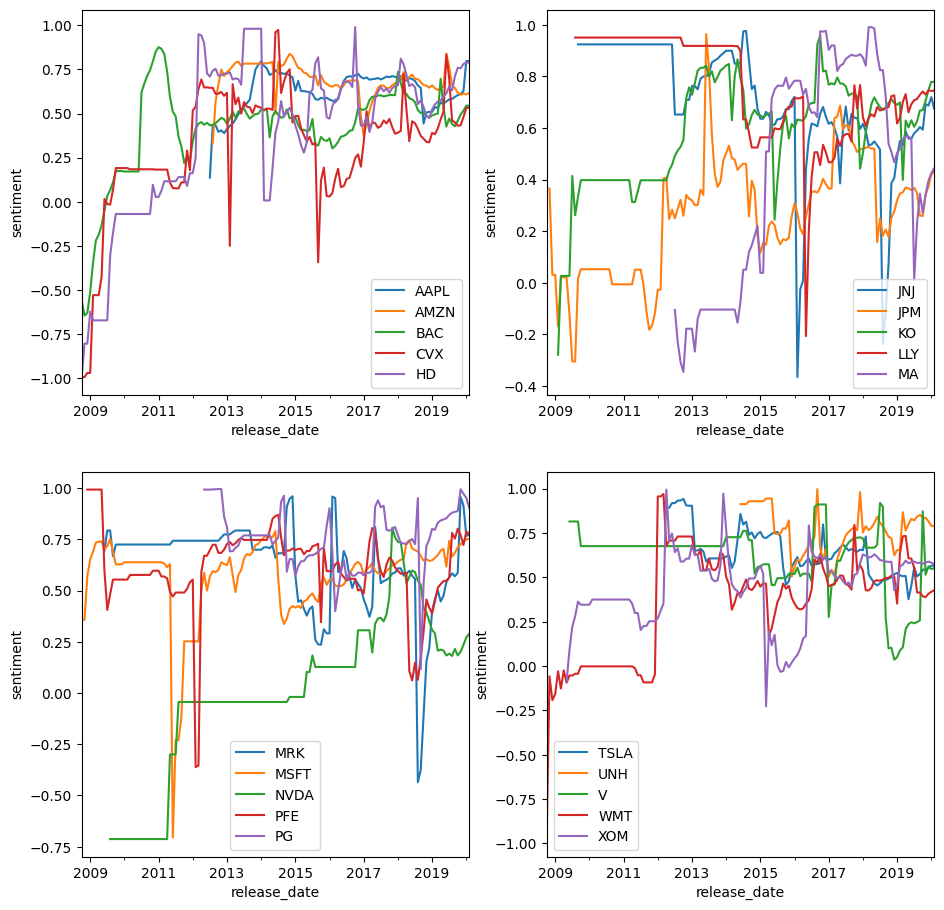

In [16]:
plot_sentiment(sentiment_data_df, sentiment_df, "")

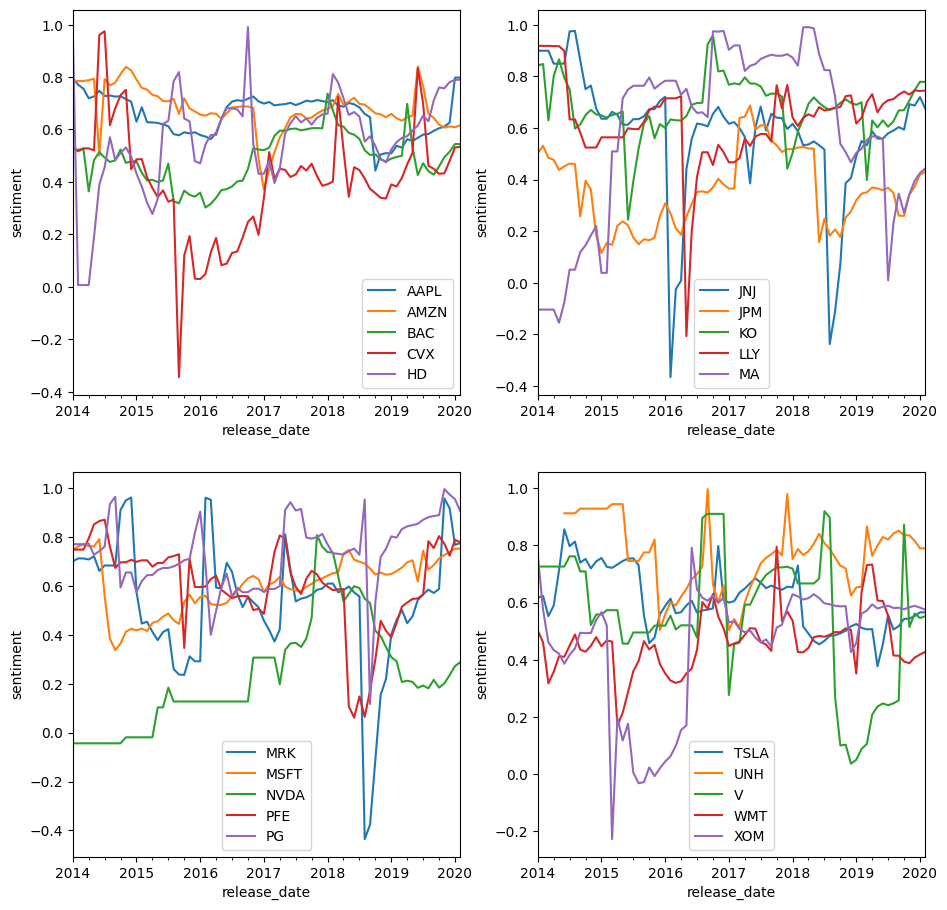

In [17]:
sentiment_data_df = sentiment_data_df[sentiment_data_df.index >= pd.to_datetime('2014-01-01')]
plot_sentiment(sentiment_data_df, sentiment_df, "")

The stocks in high to low order of sentiment data:

In [18]:
stocks = pd.read_csv(pathlib.Path("../data/used_companies.csv"))
stocks

,AAPL,MSFT,BAC,AMZN,TSLA,XOM,JPM,KO,WMT,CVX,JNJ,HD,PG,MRK,PFE,LLY,NVDA,MA,UNH,V


Throwing away the data of the 5 stocks with the least amount of sentiment data: V, UNH, MA, NVDA and LLY

In [19]:
def delete(stock):
    del sentiment_data_df[f"{stock}_mean"]
    del sentiment_data_df[f"{stock}_sum"]
    del sentiment_data_df[f"{stock}_run_mean"]
    del stocks[f"{stock}"]
    del sentiment_df[f"{stock}"]

In [20]:
delete_list = ["LLY", "NVDA", "MA", "UNH", "V"]
for stock in delete_list:
    delete(stock)

# ADF Test

In [21]:
def stationary(data, variable) -> bool:
    """
    Test stationarity with augmented Dickey Fuller test. Testing the following hypothesis with
    the resulting p-value:

    H0: The data has a unit root and is stationary.

    Returns true if stationary else return false
    """

    print(f"Output results augmented Dickey Fuller test for variable: {variable}")
    results_augmented_dickey_fuller = adfuller(data)
    print('ADF Statistic: %f' % results_augmented_dickey_fuller[0])
    print('p-value: %f' % results_augmented_dickey_fuller[1])
    print('Critical Values:')
    for key, value in results_augmented_dickey_fuller[4].items():
        print('\t%s: %.3f' % (key, value))

    if results_augmented_dickey_fuller[1] <= 0.05:
        print("Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary")
        print('\n')
        return True
    else:
        print("Conclusion: p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary")
        print('\n')
        return False

In [22]:
def check_stationarity(sentiment_data_df, column):
    not_stationary_tickers = []

    for ticker in stocks:
        if not stationary(sentiment_data_df[f"{ticker}_{column}"], ticker):
            not_stationary_tickers.append(ticker)

    return not_stationary_tickers

In [23]:
check_stationarity(sentiment_data_df, "mean")

Output results augmented Dickey Fuller test for variable: AAPL
ADF Statistic: -3.816080
p-value: 0.002747
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589
Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


Output results augmented Dickey Fuller test for variable: MSFT
ADF Statistic: -3.897593
p-value: 0.002053
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589
Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


Output results augmented Dickey Fuller test for variable: BAC
ADF Statistic: -2.034488
p-value: 0.271659
Critical Values:
	1%: -3.527
	5%: -2.904
	10%: -2.589
Conclusion: p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary


Output results augmented Dickey Fuller test for variable: AMZN
ADF Statistic: -5.927052
p-value: 0.000000
Critical Values:
	1%: -3.523
	5%: -2.902
	10%: -2.588
Conclusio

['BAC']

Only the monthly average of BAC is not stationary

In [24]:
check_stationarity(sentiment_data_df, "sum")

Output results augmented Dickey Fuller test for variable: AAPL
ADF Statistic: -4.835208
p-value: 0.000047
Critical Values:
	1%: -3.523
	5%: -2.902
	10%: -2.588
Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


Output results augmented Dickey Fuller test for variable: MSFT
ADF Statistic: -2.600955
p-value: 0.092800
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589
Conclusion: p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary


Output results augmented Dickey Fuller test for variable: BAC
ADF Statistic: -1.422244
p-value: 0.571567
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591
Conclusion: p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary


Output results augmented Dickey Fuller test for variable: AMZN
ADF Statistic: -3.000067
p-value: 0.034888
Critical Values:
	1%: -3.523
	5%: -2.902
	10%: -2.588
Conclusi

['MSFT', 'BAC', 'XOM', 'HD']

The stocks above are not stationary for the sum of the sentiment

In [25]:
check_stationarity(sentiment_data_df, "run_mean")

Output results augmented Dickey Fuller test for variable: AAPL
ADF Statistic: -2.166686
p-value: 0.218558
Critical Values:
	1%: -3.523
	5%: -2.902
	10%: -2.588
Conclusion: p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary


Output results augmented Dickey Fuller test for variable: MSFT
ADF Statistic: -2.235526
p-value: 0.193605
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589
Conclusion: p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary


Output results augmented Dickey Fuller test for variable: BAC
ADF Statistic: -2.426283
p-value: 0.134455
Critical Values:
	1%: -3.523
	5%: -2.902
	10%: -2.588
Conclusion: p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary


Output results augmented Dickey Fuller test for variable: AMZN
ADF Statistic: -3.060236
p-value: 0.029639
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589
Conclus

['AAPL', 'MSFT', 'BAC', 'TSLA', 'XOM', 'JPM', 'CVX', 'PFE']

Stocks above are not stationary for the running mean

# Making time series stationary

To make the time series stationary we can compute the deratitive by taking the percentage differences.

In [26]:
pd.options.mode.chained_assignment = None
for column in sentiment_data_df:
    sentiment_data_df.loc[:,f"{column}_prc"] = sentiment_data_df.loc[:,column].astype(float).pct_change()

sentiment_data_df = sentiment_data_df.reindex(sorted(sentiment_data_df.columns), axis=1)
sentiment_data_df


ticker,AAPL_mean,AAPL_mean_prc,AAPL_run_mean,AAPL_run_mean_prc,AAPL_sum,AAPL_sum_prc,AMZN_mean,AMZN_mean_prc,AMZN_run_mean,AMZN_run_mean_prc,...,WMT_run_mean,WMT_run_mean_prc,WMT_sum,WMT_sum_prc,XOM_mean,XOM_mean_prc,XOM_run_mean,XOM_run_mean_prc,XOM_sum,XOM_sum_prc
release_date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,0.857088,NaN,0.796241,NaN,17.141767,NaN,0.998100,NaN,0.784967,NaN,...,0.502336,NaN,3.339025,NaN,0.650167,NaN,0.766532,NaN,3.901000,NaN
2014-02-01,0.703712,-0.178951,0.770737,-0.032031,15.481658,-0.096846,0.998100,0.000000,0.784967,0.000000,...,0.460004,-0.084271,3.991433,0.195389,0.393617,-0.394591,0.573475,-0.251858,1.180850,-0.697296
2014-03-01,0.621087,-0.117413,0.755692,-0.019521,8.695217,-0.438354,0.998100,0.000000,0.784967,0.000000,...,0.316950,-0.310983,-1.666400,-1.417494,0.029525,-0.924990,0.460781,-0.196512,0.118100,-0.899987
2014-04-01,0.498430,-0.197487,0.719020,-0.048527,7.974884,-0.082842,0.825547,-0.172882,0.787795,0.003602,...,0.357829,0.128975,1.656500,-1.994059,-0.288567,-10.773638,0.433643,-0.058895,-0.865700,-8.330229
2014-05-01,0.713565,0.431625,0.726258,0.010065,12.130607,0.521101,0.958917,0.161554,0.793507,0.007251,...,0.411479,0.149932,4.981750,2.007395,0.571917,-2.981922,0.420941,-0.029290,3.431500,-4.963844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-01,0.727041,0.030219,0.604543,0.016561,20.357161,0.030219,0.516684,-0.131673,0.618343,-0.039937,...,0.393415,-0.048865,2.209500,-0.498769,0.519429,-0.131091,0.576152,-0.009376,12.466299,-0.131091
2019-11-01,0.697606,-0.040486,0.611289,0.011159,18.137767,-0.109023,0.551874,0.068109,0.606985,-0.018368,...,0.387508,-0.015013,7.434600,2.364834,0.666542,0.283220,0.583714,0.013124,14.663918,0.176285
2019-12-01,0.809745,0.160748,0.626258,0.024488,25.102093,0.383968,0.638340,0.156677,0.611497,0.007433,...,0.406892,0.050021,4.361650,-0.413331,0.647223,-0.028983,0.588273,0.007811,14.238912,-0.028983


In [27]:
sentiment_data_df = sentiment_data_df.fillna(method="ffill")
sentiment_data_df.replace([np.inf, -np.inf, "inf", np.NaN], 0, inplace=True)
sentiment_data_df = sentiment_data_df.drop(sentiment_data_df.index[0])

In [28]:
sentiment_data_df

ticker,AAPL_mean,AAPL_mean_prc,AAPL_run_mean,AAPL_run_mean_prc,AAPL_sum,AAPL_sum_prc,AMZN_mean,AMZN_mean_prc,AMZN_run_mean,AMZN_run_mean_prc,...,WMT_run_mean,WMT_run_mean_prc,WMT_sum,WMT_sum_prc,XOM_mean,XOM_mean_prc,XOM_run_mean,XOM_run_mean_prc,XOM_sum,XOM_sum_prc
release_date,,,,,,,,,,,,,,,,,,,,,
2014-02-01,0.703712,-0.178951,0.770737,-0.032031,15.481658,-0.096846,0.998100,0.000000,0.784967,0.000000,...,0.460004,-0.084271,3.991433,0.195389,0.393617,-0.394591,0.573475,-0.251858,1.180850,-0.697296
2014-03-01,0.621087,-0.117413,0.755692,-0.019521,8.695217,-0.438354,0.998100,0.000000,0.784967,0.000000,...,0.316950,-0.310983,-1.666400,-1.417494,0.029525,-0.924990,0.460781,-0.196512,0.118100,-0.899987
2014-04-01,0.498430,-0.197487,0.719020,-0.048527,7.974884,-0.082842,0.825547,-0.172882,0.787795,0.003602,...,0.357829,0.128975,1.656500,-1.994059,-0.288567,-10.773638,0.433643,-0.058895,-0.865700,-8.330229
2014-05-01,0.713565,0.431625,0.726258,0.010065,12.130607,0.521101,0.958917,0.161554,0.793507,0.007251,...,0.411479,0.149932,4.981750,2.007395,0.571917,-2.981922,0.420941,-0.029290,3.431500,-4.963844
2014-06-01,0.916550,0.284465,0.747577,0.029355,17.414442,0.435579,0.502565,-0.475903,0.499665,-0.370308,...,0.409961,-0.003689,1.541900,-0.690490,0.263183,-0.539822,0.385725,-0.083662,0.526367,-0.846607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-01,0.727041,0.030219,0.604543,0.016561,20.357161,0.030219,0.516684,-0.131673,0.618343,-0.039937,...,0.393415,-0.048865,2.209500,-0.498769,0.519429,-0.131091,0.576152,-0.009376,12.466299,-0.131091
2019-11-01,0.697606,-0.040486,0.611289,0.011159,18.137767,-0.109023,0.551874,0.068109,0.606985,-0.018368,...,0.387508,-0.015013,7.434600,2.364834,0.666542,0.283220,0.583714,0.013124,14.663918,0.176285
2019-12-01,0.809745,0.160748,0.626258,0.024488,25.102093,0.383968,0.638340,0.156677,0.611497,0.007433,...,0.406892,0.050021,4.361650,-0.413331,0.647223,-0.028983,0.588273,0.007811,14.238912,-0.028983


Now lets do the ADF test again:

In [29]:
check_stationarity(sentiment_data_df, "mean_prc")

Output results augmented Dickey Fuller test for variable: AAPL
ADF Statistic: -12.470427
p-value: 0.000000
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589
Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


Output results augmented Dickey Fuller test for variable: MSFT
ADF Statistic: -9.420632
p-value: 0.000000
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589
Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


Output results augmented Dickey Fuller test for variable: BAC
ADF Statistic: -8.574320
p-value: 0.000000
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589
Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


Output results augmented Dickey Fuller test for variable: AMZN
ADF Statistic: -6.078419
p-value: 0.000000
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591
Conclusio

['XOM']

In [30]:
check_stationarity(sentiment_data_df, "run_mean_prc")

Output results augmented Dickey Fuller test for variable: AAPL
ADF Statistic: -9.489055
p-value: 0.000000
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589
Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


Output results augmented Dickey Fuller test for variable: MSFT
ADF Statistic: -6.793573
p-value: 0.000000
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589
Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


Output results augmented Dickey Fuller test for variable: BAC
ADF Statistic: -8.734918
p-value: 0.000000
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589
Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


Output results augmented Dickey Fuller test for variable: AMZN
ADF Statistic: -7.120440
p-value: 0.000000
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589
Conclusion

[]

In [31]:
check_stationarity(sentiment_data_df, "sum_prc")

Output results augmented Dickey Fuller test for variable: AAPL
ADF Statistic: -8.141594
p-value: 0.000000
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589
Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


Output results augmented Dickey Fuller test for variable: MSFT
ADF Statistic: -9.990642
p-value: 0.000000
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589
Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


Output results augmented Dickey Fuller test for variable: BAC
ADF Statistic: -8.648772
p-value: 0.000000
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589
Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


Output results augmented Dickey Fuller test for variable: AMZN
ADF Statistic: -7.812374
p-value: 0.000000
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589
Conclusion

[]

In [32]:
sentiment_data_df.to_csv("../data/sentiment_data.csv")

<AxesSubplot: xlabel='release_date'>

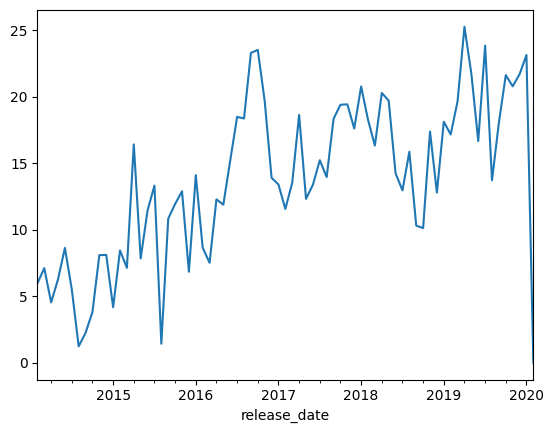

In [36]:
sentiment_data_df["AAPL_sum"].plot()